In [33]:
! pip install deepxde==0.10.0

     |████████████████████████████████| 73 kB 686 kB/s 
     |████████████████████████████████| 756 kB 8.5 MB/s 
     |████████████████████████████████| 81 kB 7.8 MB/s 
     |████████████████████████████████| 65 kB 3.0 MB/s 
  Attempting uninstall: deepxde
    Found existing installation: DeepXDE 0.14.1
    Uninstalling DeepXDE-0.14.1:
      Successfully uninstalled DeepXDE-0.14.1


In [45]:
import numpy as np
from scipy.integrate import odeint

In [46]:
import deepxde as dde
from deepxde.backend import tf

In [47]:
alpha=0.25
alpha_r=0.1
beta=0.5
gamma_r=0.095
gamma_u=0.2
mu=0.005
N=50000
E=10

In [48]:
def seirm_model_covid(
    t,
    alpha=0.25,
    alpha_r=0.1,
    beta=0.5,
    gamma_r=0.095,
    gamma_u=0.2,
    mu=0.005,
    N=50000,
    E=10):
  def func(y,t):
    alpha_u = 1.0*(1-alpha)/alpha * alpha_r
    dS = -1.0*beta*y[0]*(y[2]+y[3])/N
    dE = beta*y[0]*(y[2]+y[3])/N - alpha_r*y[1] - alpha_u*y[1]
    dI_r = alpha_r*y[1] - gamma_r*y[2] - mu*y[2]
    dI_u = alpha_u*y[1] - gamma_u*y[3]
    dR = gamma_r*y[2] + gamma_u*y[3]
    dM = mu*y[2]
    return [dS,dE,dI_r,dI_u,dR,dM]
  y0=[N, E, 0, 0, 0 ,0]
  return odeint(func, y0, t)

In [49]:
t = np.arange(1, 91,1)[:, None]
y = seirm_model_covid(np.ravel(t))
noise=0

In [50]:
if noise > 0:
    std = noise * y.std(0)
    y[1:-1, :] += np.random.normal(0, std, (y.shape[0] - 2, y.shape[1]))
    #np.savetxt("glycolysis_noise.dat", np.hstack((t, y)))

In [51]:
def pinn(data_t, data_y, noise):
    alpha = tf.math.softplus(tf.Variable(0, trainable=True, dtype=tf.float32))
    alpha_r = tf.math.softplus(tf.Variable(0, trainable=True, dtype=tf.float32))
    beta = tf.math.softplus(tf.Variable(0, trainable=True, dtype=tf.float32))
    gamma_r = tf.math.softplus(tf.Variable(0, trainable=True, dtype=tf.float32))
    gamma_u = tf.math.softplus(tf.Variable(0, trainable=True, dtype=tf.float32))
    mu = tf.math.softplus(tf.Variable(0, trainable=True, dtype=tf.float32))
    N = tf.math.softplus(tf.Variable(0, trainable=True, dtype=tf.float32))
    E = tf.math.softplus(tf.Variable(0, trainable=True, dtype=tf.float32))
    var_list = [alpha,alpha_r,beta,gamma_r,gamma_u,mu,N,E]
    def ODE(t, y):
        alpha_u = 1.0*(1-alpha)/alpha * alpha_r
        dS = -1.0*beta*y[0]*(y[2]+y[3])/N
        dE = beta*y[0]*(y[2]+y[3])/N - alpha_r*y[1] - alpha_u*y[1]
        dI_r = alpha_r*y[1] - gamma_r*y[2] - mu*y[2]
        dI_u = alpha_u*y[1] - gamma_u*y[3]
        dR = gamma_r*y[2] + gamma_u*y[3]
        dM = mu*y[2]
        return [tf.gradients(y[:, 0:1], t)[0] - dS,tf.gradients(y[:, 1:2], t)[0] - dE,tf.gradients(y[:, 2:3], t)[0] - dI_r,tf.gradients(y[:, 3:4], t)[0] - dI_u,tf.gradients(y[:, 4:5], t)[0] - dR,tf.gradients(y[:, 5:6], t)[0] - dM]
    geom = dde.geometry.TimeDomain(data_t[0, 0], data_t[-1, 0])
    # Right point
    def boundary(x, _):
        return np.isclose(x[0], data_t[-1, 0])
    y1 = data_y[-1]
    bc0 = dde.DirichletBC(geom, lambda X: y1[0], boundary, component=0)
    bc1 = dde.DirichletBC(geom, lambda X: y1[1], boundary, component=1)
    bc2 = dde.DirichletBC(geom, lambda X: y1[2], boundary, component=2)
    bc3 = dde.DirichletBC(geom, lambda X: y1[3], boundary, component=3)
    bc4 = dde.DirichletBC(geom, lambda X: y1[4], boundary, component=4)
    bc5 = dde.DirichletBC(geom, lambda X: y1[5], boundary, component=5)
    n = len(data_t)
    idx = np.append(
        np.random.choice(np.arange(1, n - 1), size=n // 4, replace=False), [0, n - 1]
    )
    ptset = dde.bc.PointSet(data_t[idx])
    inside = lambda x, _: ptset.inside(x)
    # Inputs for the training using S5 and S6
    observe_y4 = dde.DirichletBC(
        geom, ptset.values_to_func(data_y[idx, 4:5]), inside, component=4
    )
    observe_y5 = dde.DirichletBC(
        geom, ptset.values_to_func(data_y[idx, 5:6]), inside, component=5
    )
    data = dde.data.PDE(
        geom,
        ODE,
        [bc0, bc1, bc2, bc3, bc4, bc5, observe_y4, observe_y5],
        anchors=data_t,
    )

    net = dde.maps.FNN([1] + [128] * 3 + [7], "swish", "Glorot normal")
    # Apply appropriate Feature Transform
    model = dde.Model(data, net)

    checkpointer = dde.callbacks.ModelCheckpoint(
        "./model/model.ckpt", verbose=1, save_better_only=True, period=1000
    )
    variable = dde.callbacks.VariableValue(
        var_list, period=1000, filename="variables.dat", precision=3,
    )
    callbacks = [checkpointer, variable]

    bc_weights = [1, 1, 1, 1, 1]
    if noise >= 0.1:
        bc_weights = [w * 10 for w in bc_weights]
    data_weights = [1e3, 1]
    # Large noise requires small data_weights
    if noise >= 0.1:
        data_weights = [w / 10 for w in data_weights]
    model.compile("adam", lr=1e-3, loss_weights=[0] * 7 + bc_weights + data_weights)
    model.train(epochs=1000, display_every=1000)
    ode_weights = [1e-3, 1e-3,1e-3, 1e-3,1e-3,1e-3,1e-3]
    # Large noise requires large ode_weights
    if noise > 0:
        ode_weights = [10 * w for w in ode_weights]
    model.compile("adam", lr=1e-3, loss_weights=ode_weights + bc_weights + data_weights)
    losshistory, train_state = model.train(
        epochs=20000 if noise == 0 else 20000,
        display_every=1000,
        callbacks=callbacks,
        disregard_previous_best=True,
        # model_restore_path="./model/model.ckpt-"
    )
    dde.saveplot(losshistory, train_state, issave=True, isplot=True)
    var_list = [model.sess.run(v) for v in var_list]
    return var_list,model

Compiling model...
Building feed-forward neural network...
'build' took 0.133775 s



/usr/local/lib/python3.7/dist-packages/deepxde/maps/fnn.py:82: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_regularizer=self.regularizer,
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


'compile' took 5.412900 s

Initializing variables...
Training model...

Step      Train loss                                                                                                                                      Test loss                                                                                                                                       Test metric
0         [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 3.07e+03, 1.86e+05, 4.32e+04, 2.12e+09, 3.29e+05, 6.70e+11, 9.42e+04]    [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
1000      [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 7.36e+00, 6.75e-01, 1.17e+01, 1.52e+07, 1.23e+01, 4.99e+09, 3.04e+02]    [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  

Best model 

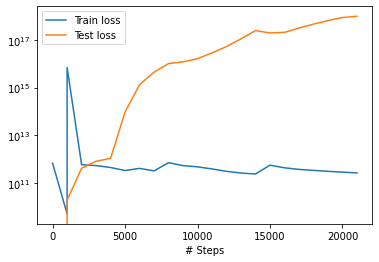

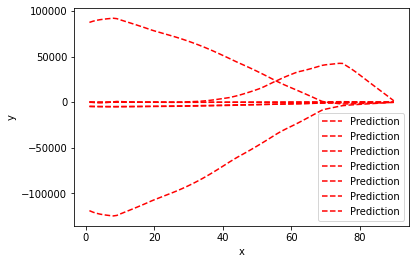

In [52]:
# Train
var_list = pinn(t, y, noise)

In [53]:
var_list[0]

[0.5643881,
 0.8341429,
 0.6104228,
 0.1443192,
 0.25407273,
 0.35505974,
 0.78292733,
 0.6931472]

In [54]:
# Prediction
y = seirm_model_covid(np.ravel(t), alpha=var_list[0][0],
                      alpha_r=var_list[0][1],
                      beta=var_list[0][2],
                      gamma_r=var_list[0][3],
                      gamma_u=var_list[0][4],
                      mu=var_list[0][5],
                      N=var_list[0][6],
                      E=var_list[0][7])

In [55]:
import matplotlib.pyplot as plt
def plotGenData(Data):
    figure = plt.figure(figsize = (10.24, 7.68))
    plt.plot(Data[:,0], label = 'S')
    plt.plot(Data[:,1], label = 'E')
    plt.plot(Data[:,2], label = 'I_r')
    plt.plot(Data[:,3], label = 'I_u')
    plt.plot(Data[:,4], label = 'R')
    plt.plot(Data[:,5], label = 'M')
    plt.legend()
    plt.show()

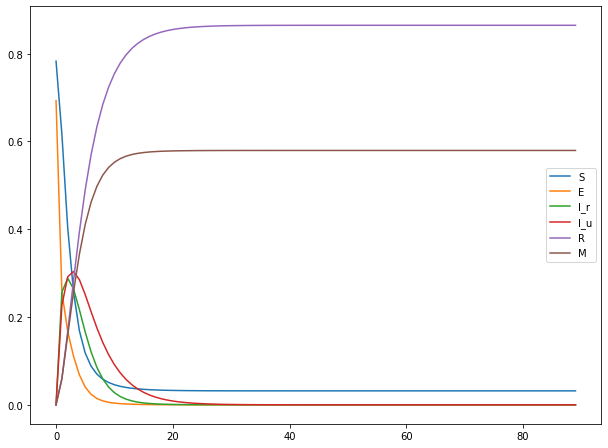

In [56]:
plotGenData(y)

In [57]:
YCases = N-y[:,0]-y[:,1]
YCases = np.gradient(YCases)
YDeaths = y[:,5]
YDeaths = np.gradient(YDeaths)
YReports = alpha * YCases
YData = np.hstack((YReports, YDeaths))
YData = np.array(YData, dtype = float)
rng = np.random.default_rng()
Noise = 2 * rng.normal(size=YData.size)
YData += Noise

In [62]:
from scipy import optimize,integrate

In [59]:
def FitSEIRM(x, alpha, alpha_r, beta, gamma_r, gamma_u, mu, E0, N):        
    S0 = N - E0
    
    ret =  integrate.odeint(func = SEIRM, y0 = (S0, E0, 0, 0, 0 ,0), t = x, args = (alpha, alpha_r, beta, gamma_r, gamma_u, mu,N))

    I = N - ret[:,0] - ret[:,1]
    I = alpha*np.gradient(I)
    M = ret[:,5]
    M = np.gradient(M)
    IM = np.hstack((I,M))

    return IM

In [60]:
XData = list(range(1, 91,1))
XData = np.array(XData, dtype = float)

[6.23341495e-02 1.02284262e-01 3.62952136e-01 6.28481020e-01
 5.32345004e-04 2.55076988e-09 4.12487137e-08 3.45324718e+02]


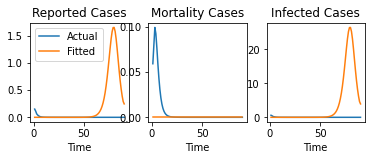

In [63]:
ParaOpt, ParaCov = optimize.curve_fit(f = FitSEIRM, xdata = XData, ydata = YData, maxfev = 10000, p0 = (1, 1, 1, 1, 1,  1, 10, N), bounds = [[0,0,0,0,0,0,0,0], [1,1,1,1,1,1,N,N]])
    
print(ParaOpt)
    
Result_good = FitSEIRM(XData, *ParaOpt[0:8])

plt.subplot(2,3,4)
plt.plot(XData, YReports, label='Actual')
plt.plot(XData, Result_good[:len(YCases)], label='Fitted')
plt.xlabel('Time')
plt.title('Reported Cases')
plt.legend()
    
plt.subplot(2,3,5)
plt.plot(XData, YDeaths, label='Actual')
plt.plot(XData, Result_good[len(YCases):], label='Fitted')
plt.xlabel('Time')
plt.title('Mortality Cases')
#plt.legend()
    
plt.subplot(2,3,6)
plt.plot(XData, YCases, label='Actual')
plt.plot(XData, Result_good[:len(YCases)]/ParaOpt[0], label='Predicted')
plt.xlabel('Time')
plt.title('Infected Cases')
#plt.legend()

plt.savefig("result.png")
plt.show()